# 04_03: Cleaning weather data

In [5]:
import math
import collections
import dataclasses
import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as pp

In [1]:
import getweather

We pick up where we left, and load temperature data for Pasadena, California. This is a _time series_: a sequence of values organized chronologically, usually with equal cadence---that is, the same time interval between every two consecutive samples.

In [16]:
pasadena = getweather.getyear('PASADENA', ['TMIN', 'TMAX'], 2001)

To get a sense of the data, one often begins by computing its average value, and its extrema (the minimum and maximum). With NumPy, we use `mean`, `min`, and `max`. [type] But wait, we get nans. What's going on here?

In [17]:
np.mean(pasadena['TMIN']), np.min(pasadena['TMIN']), np.max(pasadena['TMIN'])

(nan, nan, nan)

This means that some values are missing from the data file, and are indeed represented as NaN. Now, the mean of a sequence that includes a NaN is going to be, well, NaN!

In [19]:
pasadena['TMIN']

array([ 9.4,  8.3,  8.9,  8.3, 10. , 10.6,  7.2,  7.2,  7.8,  6.1,  5.6,
        6.1,  5. ,  3.9,  4.4,  2.8,  5. ,  3.9,  5.6,  7.2,  7.2,  8.9,
        5.6,  6.7,  3.3,  5.6,  3.3,  3.3,  3.3,  3.9,  5. ,  5. ,  6.1,
        nan,  7.2, 13.9, 11.1,  5.6,  2.2,  3.9,  6.1,  3.3,  5.6,  6.1,
        2.8,  2.8,  4.4,  7.8, 10. ,  9.4,  5.6,  5.6,  7.8,  5. ,  3.9,
        6.7,  7.2,  7.8,  6.7,  5. ,  5.6,  8.3,  9.4, 10. ,  9.4, 10. ,
        8.9, 10.6,  6.1,  8.9,  8.3,  7.2,  7.8, 10. , 10. ,  7.8, 10.6,
       13.3, 14.4, 10.6, 11.7, 11.1,  9.4, 10. , 12.2, 10. , 11.1, 12.8,
       12.8, 12.8, 12.2, 11.1, 10.6,  8.3,  8.3,  6.1,  7.2,  3.3, 16.1,
        3.9,  8.9,  7.8,  6.7,  7.2,  7.2,  9.4,  9.4, 12.2, 11.1,  8.9,
        6.1,  7.2, 10. , 10. , 16.1, 12.2, 12.8, 11.7,  nan, 11.1, 11.7,
       12.2, 11.1, 10.6, 11.1, 12.2, 13.3, 15.6, 16.1, 14.4, 13.3, 13.9,
       13.3, 10.6, 13.3, 13.9, 14.4, 15. ,  nan, 11.1, 14.4, 15. , 15.6,
       15. , 15.6, 16.7, 14.4, 14.4, 12.8, 13.9, 15

In fact, how many values are missing? The NumPy function `isnan` creates a boolean array of NaN-ness:

In [12]:
np.isnan(pasadena['TMIN'])

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False,

We can then count the instances of True by using a neat trick: if we do arithmetics with booleans in Python, they are converted to integers, with False counting as zero, and True as 1. It follows that we can count the True's in a boolean array by obtaining its sum with np.sum.

In [14]:
np.sum(np.isnan(pasadena['TMIN']))

15

What can we do? Missing values are so common in practice that numpy offers versions of its functions that simply ignore them:

In [15]:
np.nanmin(pasadena['TMIN']), np.nanmax(pasadena['TMAX'])

(2.2, 41.1)

For some applications, though, we do need an uninterrupted series of number. We could just set the nans to the average of the column. This is yet another application of fancy indexing, because we want to modify only the nan elements. So we write...

In [20]:
pasadena['TMIN'][np.isnan(pasadena['TMIN'])] = np.nanmean(pasadena['TMIN'])
pasadena['TMAX'][np.isnan(pasadena['TMAX'])] = np.nanmean(pasadena['TMAX'])

It worked! We can tell which values we changed because they have more digits than all the others, which were encoded with limited precision in the GHCN data.

In [21]:
pasadena['TMIN']

array([ 9.4       ,  8.3       ,  8.9       ,  8.3       , 10.        ,
       10.6       ,  7.2       ,  7.2       ,  7.8       ,  6.1       ,
        5.6       ,  6.1       ,  5.        ,  3.9       ,  4.4       ,
        2.8       ,  5.        ,  3.9       ,  5.6       ,  7.2       ,
        7.2       ,  8.9       ,  5.6       ,  6.7       ,  3.3       ,
        5.6       ,  3.3       ,  3.3       ,  3.3       ,  3.9       ,
        5.        ,  5.        ,  6.1       , 11.45314286,  7.2       ,
       13.9       , 11.1       ,  5.6       ,  2.2       ,  3.9       ,
        6.1       ,  3.3       ,  5.6       ,  6.1       ,  2.8       ,
        2.8       ,  4.4       ,  7.8       , 10.        ,  9.4       ,
        5.6       ,  5.6       ,  7.8       ,  5.        ,  3.9       ,
        6.7       ,  7.2       ,  7.8       ,  6.7       ,  5.        ,
        5.6       ,  8.3       ,  9.4       , 10.        ,  9.4       ,
       10.        ,  8.9       , 10.6       ,  6.1       ,  8.9 

The integrated dataset can be plotted without discontinuities.

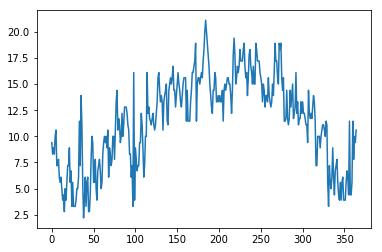

In [33]:
pp.plot(pasadena['TMIN'])

A more powerful approach to restoring missing values is _interpolation_. That is, use neighbor values to compute a plausible number for the missing value. Let me demonstrate in a toy problem: let's say we measure a function y defined at integers x between 0 and 8, but we lack some of the values. Let me show all this in a plot.

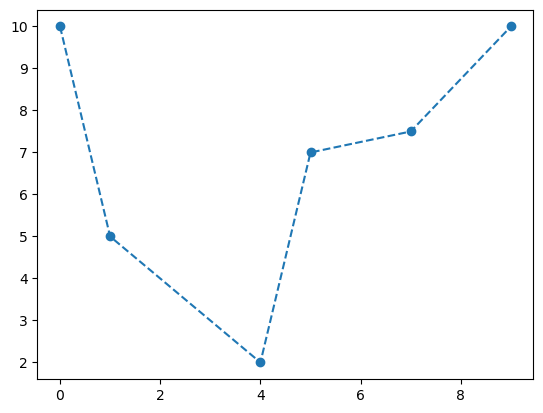

In [30]:
xdata = np.array([0,1,4,5,7,9], 'd')
ydata = np.array([10,5,2,7,7.5,10], 'd')

pp.plot(xdata, ydata, '--o') # plot with dashed lines and thick dots

By interpolating, we can compute values for this series at smaller x intervals. We define the desired x values using `np.linspace`.

In [39]:
xnew = np.linspace(0, 9, 19)
xnew

array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5, 6. ,
       6.5, 7. , 7.5, 8. , 8.5, 9. ])

To interpolate with NumPy, we use `np.interp`, which takes three arguments: the new x values, the existing x values, and the existing y data. This yields _linear interpolation_, which is in effect fitting straight segments between the existing data points. 

In [49]:
ynew = np.interp(xnew, xdata, ydata)

I will plot the newly interpolated data, and superimpose the old vectors (in orange) to show that interpolation at an existing location yields the same value.

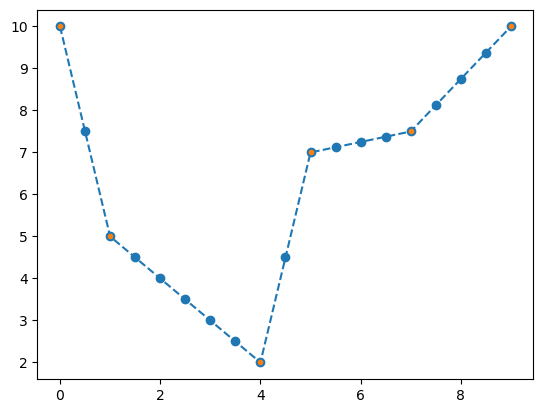

In [50]:
pp.plot(xnew, ynew, '--o')
pp.plot(xdata, ydata, '.')

For more sophisticated interpolation schemes you can look at what is available in the scientific computation library `scipy`, and specifically in `scipy.interpolate`.

Let's use interpolation to fill missing values in the Pasadena temperature data. I need to load the data again, since we "fixed" it using mean values.

In [52]:
pasadena = getweather.getyear('PASADENA', ['TMIN', 'TMAX'], 2001)

Here, broken again. To interpolate, we select the good data points, those that are _not_ nan. Then we make an array of the x values for which we want values: all days from 1 to 365. And then we apply `np.interp`.

In [53]:
good = ~np.isnan(pasadena['TMIN']) # tilde is negation
x = np.arange(0, 365)

np.interp(x, x[good], pasadena['TMIN'][good])

array([ 9.4  ,  8.3  ,  8.9  ,  8.3  , 10.   , 10.6  ,  7.2  ,  7.2  ,
        7.8  ,  6.1  ,  5.6  ,  6.1  ,  5.   ,  3.9  ,  4.4  ,  2.8  ,
        5.   ,  3.9  ,  5.6  ,  7.2  ,  7.2  ,  8.9  ,  5.6  ,  6.7  ,
        3.3  ,  5.6  ,  3.3  ,  3.3  ,  3.3  ,  3.9  ,  5.   ,  5.   ,
        6.1  ,  6.65 ,  7.2  , 13.9  , 11.1  ,  5.6  ,  2.2  ,  3.9  ,
        6.1  ,  3.3  ,  5.6  ,  6.1  ,  2.8  ,  2.8  ,  4.4  ,  7.8  ,
       10.   ,  9.4  ,  5.6  ,  5.6  ,  7.8  ,  5.   ,  3.9  ,  6.7  ,
        7.2  ,  7.8  ,  6.7  ,  5.   ,  5.6  ,  8.3  ,  9.4  , 10.   ,
        9.4  , 10.   ,  8.9  , 10.6  ,  6.1  ,  8.9  ,  8.3  ,  7.2  ,
        7.8  , 10.   , 10.   ,  7.8  , 10.6  , 13.3  , 14.4  , 10.6  ,
       11.7  , 11.1  ,  9.4  , 10.   , 12.2  , 10.   , 11.1  , 12.8  ,
       12.8  , 12.8  , 12.2  , 11.1  , 10.6  ,  8.3  ,  8.3  ,  6.1  ,
        7.2  ,  3.3  , 16.1  ,  3.9  ,  8.9  ,  7.8  ,  6.7  ,  7.2  ,
        7.2  ,  9.4  ,  9.4  , 12.2  , 11.1  ,  8.9  ,  6.1  ,  7.2  ,
      

It seems to work well. We celebrate by generalizing our Pasadena-centric code so that it can fill up holes in any array by interpolating it.

In [55]:
def fillnans(array):
    good = ~np.isnan(array)
    x = np.arange(len(array))

    return np.interp(x, x[good], array[good])

And finally we can plot the interpolated temperature series in all their glory.

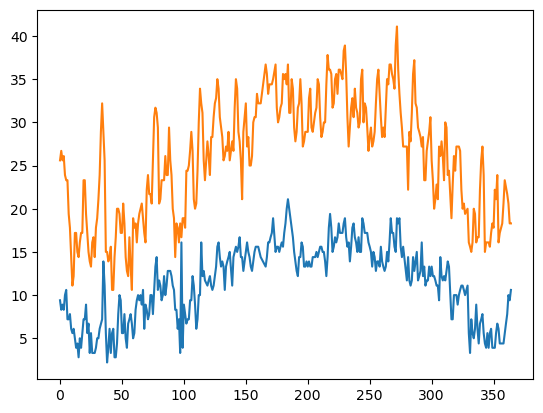

In [56]:
pp.plot(fillnans(pasadena['TMIN']))
pp.plot(fillnans(pasadena['TMAX']))